In [1766]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

from torch.utils.data import DataLoader
from torch.func import vmap, jacrev, functional_call

In [1767]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", device)

Using mps


In [1768]:
transform = transforms.Compose([transforms.ToTensor()])
# train_set = datasets.CIFAR10('CIFAR10', train=True, transform=transform, download=False)
# test_set = datasets.CIFAR10('CIFAR10', train=False, transform=transform, download=False)
train_set = datasets.MNIST('MNIST', train=True, transform=transform, download=False)
test_set = datasets.MNIST('MNIST', train=False, transform=transform, download=False)
train_loader = DataLoader(train_set, batch_size=100, shuffle=False)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False)

In [1776]:
class FeedForwardNetwork(nn.Module):
    def __init__(self):
        super(FeedForwardNetwork, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 10)
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()
        # self.tanh = nn.Tanh()
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        """
        Input:
            x: (B, C, H, W)
        """
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        # x = self.sigmoid(self.fc1(x))
        # x = self.tanh(self.fc1(x))
        x = self.fc2(x)

        return self.softmax(x)

In [1777]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(26*26*2, 10)
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()
        # self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        # x = self.sigmoid(self.conv1(x))
        # x = self.tanh(self.conv1(x))

        x = x.view(x.shape[0], -1)
        x = self.fc1(x)

        return self.softmax(x)

In [1778]:
def train(model, data_loader, batch_size=100, epochs=15, lr=1e-3):
    train_loss = []
    train_acc = []
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0.0

        model.train()
        for i, (X, y) in enumerate(data_loader):
            optimizer.zero_grad()

            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

            pred = torch.argmax(y_pred, 1)
            running_loss += loss.detach().item()
            correct += (sum(pred==y)).item()
        
        train_loss.append(running_loss / (len(data_loader)*batch_size))
        train_acc.append(correct / (len(data_loader)*batch_size))
        print("Epoch {:d}, Training Loss: {:.3f}, Accuracy: {:.3f}".format(epoch+1, running_loss/(len(data_loader)*batch_size), correct/(len(data_loader)*batch_size)))

    return train_loss, train_acc

In [1779]:
def train_modified(model, data_loader, noise_prob, noise_lvl, batch_size=100, epochs=15, lr=1e-3):
    train_loss = []
    train_acc = []
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0.0

        model.train()
        for i, (X, y) in enumerate(data_loader):
            optimizer.zero_grad()

            X, y = X.to(device), y.to(device)

            x = X.view(X.shape[0], -1)
            x = model.fc1(x)
            x = model.relu(x)
            # x = model.sigmoid(x)
            # x = model.tanh(x)

            damage_mask = (torch.rand(x.shape) > noise_prob)
            noise_mask = (torch.randn(x.shape) * noise_lvl)
            noise_mask *= ~(damage_mask.detach().clone())
            noise_mask = noise_mask.float()

            damage_mask = damage_mask.to(device)
            noise_mask = noise_mask.to(device)
            x = x * damage_mask
            x = x + noise_mask
            
            x = model.fc2(x)

            y_pred = model.softmax(x)

            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

            pred = torch.argmax(y_pred, 1)
            running_loss += loss.detach().item()
            correct += (sum(pred==y)).item()
        
        train_loss.append(running_loss / (len(data_loader)*batch_size))
        train_acc.append(correct / (len(data_loader)*batch_size))
        print("Epoch {:d}, Training Loss: {:.3f}, Accuracy: {:.3f}".format(epoch+1, running_loss/(len(data_loader)*batch_size), correct/(len(data_loader)*batch_size)))

    return train_loss, train_acc

In [1780]:
def test(model, data_loader, batch_size=100):
    correct = 0.0
    running_loss = 0.0
    loss_fn = nn.CrossEntropyLoss()

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            pred = torch.argmax(y_pred, 1)
            running_loss += loss.detach().item()
            correct += (sum(pred==y)).item()

        print("Test Loss: {:.3f}, Accuracy: {:.3f}".format(running_loss/(len(data_loader)*batch_size), correct/(len(data_loader)*batch_size)))
    
    return running_loss/(len(data_loader)*batch_size), correct/(len(data_loader)*batch_size)

In [1797]:
model = FeedForwardNetwork().to(device)
# model = CNN().to(device)
model

FeedForwardNetwork(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [1801]:
# train_loss, train_acc = train(model, train_loader, epochs=10)
train_loss, train_acc = train_modified(model, train_loader, noise_prob=0.9, noise_lvl=1.0, epochs=10)

Epoch 1, Training Loss: 0.020, Accuracy: 0.510
Epoch 2, Training Loss: 0.019, Accuracy: 0.535
Epoch 3, Training Loss: 0.019, Accuracy: 0.553
Epoch 4, Training Loss: 0.019, Accuracy: 0.562
Epoch 5, Training Loss: 0.019, Accuracy: 0.570
Epoch 6, Training Loss: 0.019, Accuracy: 0.577
Epoch 7, Training Loss: 0.019, Accuracy: 0.583
Epoch 8, Training Loss: 0.019, Accuracy: 0.587


KeyboardInterrupt: 

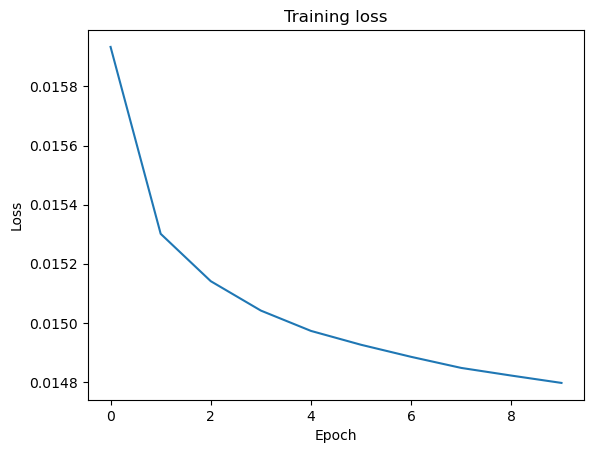

In [1762]:
plt.plot(train_loss)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

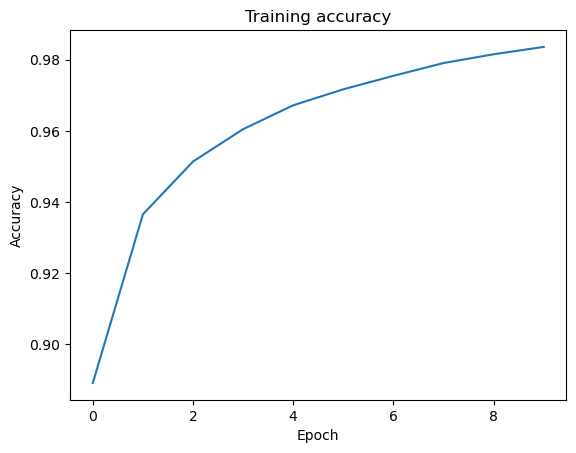

In [1763]:
plt.plot(train_acc)
plt.title("Training accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [1799]:
epochs = 10
lr = 1e-3

load_model_path = 'pretrained_model_mnist/relu_train_modified_model_prob_0.9'

In [1800]:
save_model_path = load_model_path
torch.save(model.state_dict(), save_model_path)

In [1564]:
# # model = FeedForwardNetwork().to(device)
# model = CNN().to(device)
# model.load_state_dict(torch.load(load_model_path))

<All keys matched successfully>

In [1565]:
# base_model = FeedForwardNetwork().to(device)
base_model = CNN().to(device)

if device == torch.device('cuda'):
    base_model.load_state_dict(torch.load(load_model_path))
    print("Using cuda for inferencing")
else:
    base_model.load_state_dict(torch.load(load_model_path, map_location=torch.device('cpu')))
    print("Using cpu for inferencing")

Using cpu for inferencing


In [1566]:
def test_damage_neuron(model, data_loader, noise_prob, noise_lvl):
    correct = 0.0
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            x = X.view(X.shape[0], -1)

            x = model.fc1(x)
            x = model.relu(x)
            # x = model.sigmoid(x)
            # x = model.tanh(x)

            damage_mask = (torch.rand(x.shape) > noise_prob)
            noise_mask = (torch.randn(x.shape) * noise_lvl)
            noise_mask *= ~(damage_mask.detach().clone())
            noise_mask = noise_mask.float()

            damage_mask = damage_mask.to(device)
            noise_mask = noise_mask.to(device)
            x *= damage_mask
            x += noise_mask
            
            x = model.fc2(x)
            y_pred = model.softmax(x)

            pred = torch.argmax(y_pred, 1)
            correct += (sum(pred==y)).item()

    print("Accuracy: {:.3f}".format(correct/(len(test_loader)*100)))
    return correct/(len(test_loader)*100)


In [1570]:
def test_damage_neuron_cnn(model, data_loader, noise_prob, noise_lvl):
    correct = 0.0
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            x = model.conv1(X)
            x = x.view(x.shape[0], -1)

            damage_mask = (torch.rand(x.shape) > noise_prob)
            noise_mask = (torch.randn(x.shape) * noise_lvl)
            noise_mask *= ~(damage_mask.detach().clone())
            noise_mask = noise_mask.float()

            damage_mask = damage_mask.to(device)
            noise_mask = noise_mask.to(device)
            x *= damage_mask
            x += noise_mask
            
            x = model.fc1(x)
            y_pred = model.softmax(x)

            pred = torch.argmax(y_pred, 1)
            correct += (sum(pred==y)).item()

    print("Accuracy: {:.3f}".format(correct/(len(test_loader)*100)))
    return correct/(len(test_loader)*100)


In [1559]:
def test_damage_neuron_weight_shift(model, data_loader, noise_prob, noise_lvl):
    correct = 0.0
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            x = X.view(X.shape[0], -1)

            x = model.fc1(x)
            x = model.relu(x)
            # x = model.sigmoid(x)
            # x = model.tanh(x)

            damage_mask = (torch.rand(x.shape) > noise_prob)
            noise_mask = (torch.randn(x.shape) * noise_lvl)
            noise_mask *= ~(damage_mask.detach().clone())
            noise_mask = noise_mask.float()

            damage_mask = damage_mask.to(device)
            noise_mask = noise_mask.to(device)
            x *= damage_mask
            x += noise_mask
            
            x = model.fc2(x)
            y_pred = model.softmax(x)

            pred = torch.argmax(y_pred, 1)
            correct += (sum(pred==y)).item()

    print("Accuracy: {:.3f}".format(correct/(len(test_loader)*100)))
    return correct/(len(test_loader)*100)


In [1546]:
def test_damage_weight(model, data_loader, noise_prob, noise_lvl):
    correct = 0.0
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            x = X.view(X.shape[0], -1)

            x = model.fc1(x)
            x = model.relu(x)
            # x = model.sigmoid(x)
            # x = model.tanh(x)

            fc2_original_weight = model.fc2.weight.detach().clone()
            damage_mask = (torch.rand(fc2_original_weight.shape) > noise_prob)
            noise_mask = (torch.randn(fc2_original_weight.shape) * noise_lvl)
            noise_mask *= ~(damage_mask.detach().clone())
            noise_mask = noise_mask.float()

            damage_mask = damage_mask.to(device)
            noise_mask = noise_mask.to(device)
            model.fc2.weight *= damage_mask
            model.fc2.weight += noise_mask
            
            x = model.fc2(x)

            model.fc2.weight = nn.Parameter(fc2_original_weight)
            y_pred = model.softmax(x)

            pred = torch.argmax(y_pred, 1)
            correct += (sum(pred==y)).item()

    print("Accuracy: {:.3f}".format(correct/(len(test_loader)*100)))
    return correct/(len(test_loader)*100)

In [1572]:
noise_lvl = [0.0, 2.0, 4.0, 8.0, 16.0, 32.0]
# noise_lvl = [1.0, 4.0]
# noise_lvl = [0.0]
noise_prob = [i/100 for i in range(0, 101, 20)]
base_acc_dict  = {lvl: [] for lvl in noise_lvl}
ft_acc_dict  = {lvl: [] for lvl in noise_lvl}

for prob in noise_prob:
    for lvl in noise_lvl:
        print("Noise Probability: {:.2f}, Noise Level: {:.2f}".format(prob, lvl))
        base_model_acc = test_damage_neuron_cnn(base_model, test_loader, prob, lvl)
        # fault_tolerent_model_acc = test_damage_neuron(fault_tolerent_model, test_loader, prob, lvl)
        # base_model_acc = test_damage_weight(base_model, test_loader, prob, lvl)
        # fault_tolerent_model_acc = test_damage_weight(fault_tolerent_model, test_loader, prob, lvl)

        base_acc_dict[lvl].append(base_model_acc)
        # ft_acc_dict[lvl].append(fault_tolerent_model_acc)

Noise Probability: 0.00, Noise Level: 0.00
Accuracy: 0.922
Noise Probability: 0.00, Noise Level: 2.00
Accuracy: 0.922
Noise Probability: 0.00, Noise Level: 4.00
Accuracy: 0.922
Noise Probability: 0.00, Noise Level: 8.00
Accuracy: 0.922
Noise Probability: 0.00, Noise Level: 16.00
Accuracy: 0.922
Noise Probability: 0.00, Noise Level: 32.00
Accuracy: 0.922
Noise Probability: 0.20, Noise Level: 0.00
Accuracy: 0.922
Noise Probability: 0.20, Noise Level: 2.00
Accuracy: 0.872
Noise Probability: 0.20, Noise Level: 4.00
Accuracy: 0.745
Noise Probability: 0.20, Noise Level: 8.00
Accuracy: 0.515
Noise Probability: 0.20, Noise Level: 16.00
Accuracy: 0.308
Noise Probability: 0.20, Noise Level: 32.00
Accuracy: 0.192
Noise Probability: 0.40, Noise Level: 0.00
Accuracy: 0.916
Noise Probability: 0.40, Noise Level: 2.00
Accuracy: 0.756
Noise Probability: 0.40, Noise Level: 4.00
Accuracy: 0.533
Noise Probability: 0.40, Noise Level: 8.00
Accuracy: 0.320
Noise Probability: 0.40, Noise Level: 16.00
Accuracy

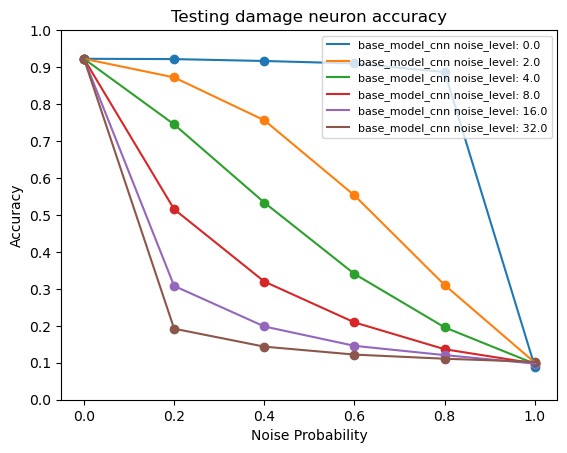

In [1574]:
for lvl in base_acc_dict:
    plt.plot(base_acc_dict[lvl], label="base_model_cnn noise_level: {:.1f}".format(lvl))
    plt.scatter([i for i in range(len(noise_prob))], base_acc_dict[lvl])

# for lvl in ft_acc_dict:
#     plt.plot(ft_acc_dict[lvl], label="fault tolerence model noise_level: {:.1f}".format(lvl))
#     plt.scatter([i for i in range(len(noise_prob))], ft_acc_dict[lvl])

plt.title("Testing damage neuron accuracy")
plt.xticks([i for i in range(len(noise_prob))], noise_prob)
plt.yticks([i/10 for i in range(11)])
plt.xlabel("Noise Probability")
plt.ylabel("Accuracy")
plt.legend(loc="upper right", prop={'size':8})
plt.show()

In [1547]:
# def test_damage_output(model, data_loader, noise_prob, noise_lvl):
#     correct = 0.0
#     with torch.no_grad():
#         for X, Y in data_loader:
#             X, Y = X.to(device), Y.to(device)
#             output = []
#             for i in range(X.shape[0]):
#                 x = X[i]
#                 y = Y[i]
#                 x = x.view(x.shape[0], -1)

#                 x = model.fc1(x)
#                 x = model.relu(x)
#                 # x = model.sigmoid(x)
#                 # x = model.tanh(x)

#                 # x: (1, output_size)
#                 out_shape, in_shape = model.fc2.weight.shape
#                 x = torch.repeat_interleave(input=x, repeats=out_shape, dim=0)
#                 # x = np.repeat(x.to('cpu'), out_shape, axis=0)
#                 # x = torch.Tensor(x).to(device)

#                 print(x)
#                 damage_mask = (torch.rand(x.shape) > noise_prob)
#                 noise_mask = (torch.randn(x.shape) * noise_lvl)
#                 noise_mask *= ~(damage_mask.detach().clone())
#                 noise_mask = noise_mask.float()

#                 damage_mask = damage_mask.to(device)
#                 noise_mask = noise_mask.to(device)
#                 x *= damage_mask
#                 x += noise_mask

#                 print(x)

#                 x *= model.fc2.weight
#                 x = torch.sum(x, dim=1)
#                 x += model.fc2.bias
#                 output.append(x.detach().clone())
            
#             output = torch.stack(output)
#             y_pred = model.softmax(output)

#             pred = torch.argmax(y_pred, 1)
#             correct += (sum(pred==Y)).item()

#     print("Accuracy: {:.3f}".format(correct/(len(test_loader)*100)))
#     return correct/(len(test_loader)*100)


In [1548]:
# noise_lvl = [0.0, 2.0, 4.0, 8.0, 16.0, 32.0]
# noise_prob = [i/100 for i in range(0, 101, 10)]
# acc_dict  = {lvl: [] for lvl in noise_lvl}

# model = FeedForwardNetwork().to(device)
# model.load_state_dict(base_model.state_dict())
# model.eval()

# for prob in noise_prob:
#     for lvl in noise_lvl:
#         print("Noise Probability: {:.2f}, Noise Level: {:.2f}".format(prob, lvl))
#         acc = test_damage_neuron(model, test_loader, prob, lvl)
#         acc_dict[lvl].append(acc)

In [1549]:
# noise_lvl = [0.0, 2.0, 4.0, 8.0, 16.0, 32.0]
# noise_prob = [i/100 for i in range(0, 101, 10)]
# acc_dict  = {lvl: [] for lvl in noise_lvl}

# model = FeedForwardNetwork().to(device)
# model.load_state_dict(base_model.state_dict())
# model.eval()

# for prob in noise_prob:
#     for lvl in noise_lvl:
#         print("Noise Probability: {:.2f}, Noise Level: {:.2f}".format(prob, lvl))
#         acc = test_damage_output(model, test_loader, prob, lvl)
#         acc_dict[lvl].append(acc)

In [1550]:
# for lvl in acc_dict:
#     plt.plot(acc_dict[lvl], label="noise_level: {:.1f}".format(lvl))
#     plt.scatter([i for i in range(len(noise_prob))], acc_dict[lvl])
# plt.title("Testing accuracy")
# plt.xticks([i for i in range(len(noise_prob))], noise_prob)
# plt.yticks([i/10 for i in range(11)])
# plt.xlabel("Noise Probability")
# plt.ylabel("Accuracy")
# plt.legend(loc="upper right", prop={'size':8})
# plt.show()

In [1551]:
class FaultTolerentFeedForwardNetwork(nn.Module):
    def __init__(self):
        super(FaultTolerentFeedForwardNetwork, self).__init__()
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300, 10)
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()
        # self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        """
        Input:
            x: (B, C, H, W)
        """
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        # x = self.sigmoid(self.fc1(x))
        # x = self.tanh(self.fc1(x))
        x = self.fc2(x)

        return self.softmax(x)

In [1426]:
fault_tolerent_model = FaultTolerentFeedForwardNetwork().to(device)
fault_tolerent_model

FaultTolerentFeedForwardNetwork(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [1469]:
copy_count = 2

new_state_dict = base_model.state_dict().copy()

new_weight = base_model.state_dict()['fc1.weight']
new_weight = new_weight.repeat_interleave(copy_count, 0)
# new_state_dict['fc1.weight'] = (new_weight / copy_count).detach().clone()
new_state_dict['fc1.weight'] = (new_weight).detach().clone()
    
new_bias = base_model.state_dict()['fc1.bias']
new_bias = new_bias.repeat_interleave(copy_count, 0)
# new_state_dict['fc1.bias'] = new_bias / copy_count
new_state_dict['fc1.bias'] = new_bias

new_weight = base_model.state_dict()['fc2.weight']
new_weight = new_weight.repeat_interleave(copy_count, 1)
new_state_dict['fc2.weight'] = (new_weight / copy_count).detach().clone()

new_bias = base_model.state_dict()['fc2.bias']
new_state_dict['fc2.bias'] = new_bias / copy_count

In [1470]:
print(base_model.state_dict()['fc2.weight'].shape)
print(fault_tolerent_model.state_dict()['fc2.weight'].shape)

torch.Size([10, 100])
torch.Size([10, 300])


In [1471]:
fault_tolerent_model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [1525]:
# noise_lvl = [0.0, 2.0, 4.0, 8.0, 16.0, 32.0]
# noise_lvl = [1.0, 4.0]
noise_lvl = [0.0]
noise_prob = [i/100 for i in range(0, 101, 20)]
base_acc_dict  = {lvl: [] for lvl in noise_lvl}
ft_acc_dict  = {lvl: [] for lvl in noise_lvl}

for prob in noise_prob:
    for lvl in noise_lvl:
        print("Noise Probability: {:.2f}, Noise Level: {:.2f}".format(prob, lvl))
        base_model_acc = test_damage_neuron(base_model, test_loader, prob, lvl)
        fault_tolerent_model_acc = test_damage_neuron(fault_tolerent_model, test_loader, prob, lvl)
        # base_model_acc = test_damage_weight(base_model, test_loader, prob, lvl)
        # fault_tolerent_model_acc = test_damage_weight(fault_tolerent_model, test_loader, prob, lvl)

        base_acc_dict[lvl].append(base_model_acc)
        ft_acc_dict[lvl].append(fault_tolerent_model_acc)

Noise Probability: 0.00, Noise Level: 0.00
Accuracy: 0.964
Accuracy: 0.954
Noise Probability: 0.20, Noise Level: 0.00
Accuracy: 0.935
Accuracy: 0.949
Noise Probability: 0.40, Noise Level: 0.00
Accuracy: 0.879
Accuracy: 0.937
Noise Probability: 0.60, Noise Level: 0.00
Accuracy: 0.757
Accuracy: 0.909
Noise Probability: 0.80, Noise Level: 0.00
Accuracy: 0.529
Accuracy: 0.806
Noise Probability: 1.00, Noise Level: 0.00
Accuracy: 0.089
Accuracy: 0.103


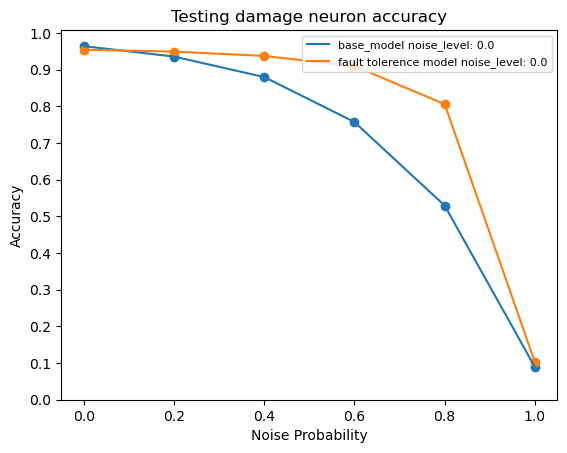

In [1526]:
for lvl in base_acc_dict:
    plt.plot(base_acc_dict[lvl], label="base_model noise_level: {:.1f}".format(lvl))
    plt.scatter([i for i in range(len(noise_prob))], base_acc_dict[lvl])

for lvl in ft_acc_dict:
    plt.plot(ft_acc_dict[lvl], label="fault tolerence model noise_level: {:.1f}".format(lvl))
    plt.scatter([i for i in range(len(noise_prob))], ft_acc_dict[lvl])

plt.title("Testing damage neuron accuracy")
plt.xticks([i for i in range(len(noise_prob))], noise_prob)
plt.yticks([i/10 for i in range(11)])
plt.xlabel("Noise Probability")
plt.ylabel("Accuracy")
plt.legend(loc="upper right", prop={'size':8})
plt.show()

In [1432]:
# # noise_lvl = [0.0, 2.0, 4.0, 8.0, 16.0, 32.0]
# # noise_lvl = [0.0, 4.0]
# noise_lvl = [5.0]
# noise_prob = [i/100 for i in range(50, 101, 20)]
# base_acc_dict  = {lvl: [] for lvl in noise_lvl}
# ft_acc_dict  = {lvl: [] for lvl in noise_lvl}

# for prob in noise_prob:
#     for lvl in noise_lvl:
#         print("Noise Probability: {:.2f}, Noise Level: {:.2f}".format(prob, lvl))
#         base_model_acc = test_damage_output(base_model, test_loader, prob, lvl)
#         ft_model_acc = test_damage_output(fault_tolerent_model, test_loader, prob, lvl)

#         base_acc_dict[lvl].append(base_model_acc)
#         ft_acc_dict[lvl].append(ft_model_acc)

In [1480]:
def layer_1_jacobian_matrix(model, data_loader):
    def fmodel(inputs):
        return model.fc2(inputs)

    jacobian_matrices = []

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        x = X.view(X.shape[0], -1)

        x = model.fc1(x)
        x = model.relu(x)
        # x = model.sigmoid(x)
        # x = model.tanh(x)

        x = x.requires_grad_(True)

        outputs = fmodel(x)
        num_outputs = outputs.size(1)
        gradients = torch.zeros(num_outputs, *x.size())
        for i in range(num_outputs):
            grad_output = torch.zeros_like(outputs)
            grad_output[:, i] = 1.0
            model.zero_grad()
            grads = torch.autograd.grad(outputs, x, grad_outputs=grad_output, create_graph=True)[0]
            gradients[i] = grads

        jacobian_matrices.append(gradients.permute(1, 0, *range(2, gradients.dim())))

    return torch.cat(jacobian_matrices, dim=0)

In [1481]:
jacobian_matrix = layer_1_jacobian_matrix(base_model, test_loader)
# jacobian_matrix = layer_1_jacobian_matrix(fault_tolerent_model, test_loader)

abs_jacobian_matrix = torch.abs(jacobian_matrix)
sensitivity_per_class = torch.sum(abs_jacobian_matrix, dim=0)
sensitive_weight = torch.argsort(sensitivity_per_class, descending=True)

In [1482]:
replace_sensitive_count = 10

new_state_dict = base_model.state_dict().copy()
# new_state_dict = fault_tolerent_model.state_dict().copy()

new_weight = base_model.state_dict()['fc2.weight'].detach().clone()
# new_weight = fault_tolerent_model.state_dict()['fc2.weight'].detach().clone()

# sorted_weight = torch.argsort(new_weight, descending=True)
# replacement_weight = torch.argsort(torch.abs(new_weight), descending=True)

for c in range(10):
    # top_sensitive_weights = sorted_weight[c][:replace_sensitive_count]
    # least_sensitive_weights = replacement_weight[c][-replace_sensitive_count:]
    top_sensitive_weights = sensitive_weight[c][:replace_sensitive_count]
    least_sensitive_weights = sensitive_weight[c][-replace_sensitive_count:]
    for i in range(replace_sensitive_count):
        new_weight[c][top_sensitive_weights[i]] /= 2
        new_weight[c][least_sensitive_weights[i]] = new_weight[c][top_sensitive_weights[i]].detach().clone()
        # new_weight[c][least_sensitive_weights[i]] = 0

new_state_dict['fc2.weight'] = new_weight.detach().clone()

In [1483]:
sensitive_model = FeedForwardNetwork().to(device)
# sensitive_model = FaultTolerentFeedForwardNetwork().to(device)
sensitive_model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [1484]:
# noise_lvl = [0.0, 2.0, 4.0, 8.0, 16.0, 32.0]
# noise_lvl = [1.0, 4.0]
noise_lvl = [0.0]
noise_prob = [i/100 for i in range(0, 101, 20)]
base_acc_dict  = {lvl: [] for lvl in noise_lvl}
sensitive_acc_dict  = {lvl: [] for lvl in noise_lvl}

for prob in noise_prob:
    for lvl in noise_lvl:
        print("Noise Probability: {:.2f}, Noise Level: {:.2f}".format(prob, lvl))
        # base_model_acc = test_damage_neuron(base_model, test_loader, prob, lvl)
        # sensitive_model_acc = test_damage_neuron(sensitive_model, test_loader, prob, lvl)
        base_model_acc = test_damage_weight(base_model, test_loader, prob, lvl)
        sensitive_model_acc = test_damage_weight(sensitive_model, test_loader, prob, lvl)

        base_acc_dict[lvl].append(base_model_acc)
        sensitive_acc_dict[lvl].append(sensitive_model_acc)

Noise Probability: 0.00, Noise Level: 0.00
Accuracy: 0.967
Accuracy: 0.959
Noise Probability: 0.20, Noise Level: 0.00
Accuracy: 0.959
Accuracy: 0.949
Noise Probability: 0.40, Noise Level: 0.00
Accuracy: 0.938
Accuracy: 0.912
Noise Probability: 0.60, Noise Level: 0.00
Accuracy: 0.878
Accuracy: 0.850
Noise Probability: 0.80, Noise Level: 0.00
Accuracy: 0.686
Accuracy: 0.643
Noise Probability: 1.00, Noise Level: 0.00
Accuracy: 0.114
Accuracy: 0.114


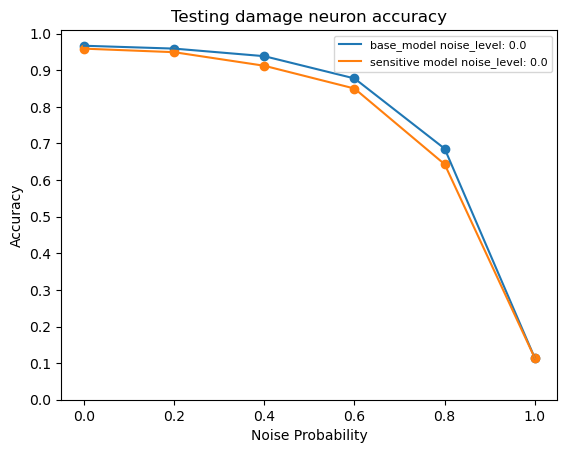

In [1485]:
for lvl in base_acc_dict:
    plt.plot(base_acc_dict[lvl], label="base_model noise_level: {:.1f}".format(lvl))
    plt.scatter([i for i in range(len(noise_prob))], base_acc_dict[lvl])

for lvl in sensitive_acc_dict:
    plt.plot(sensitive_acc_dict[lvl], label="sensitive model noise_level: {:.1f}".format(lvl))
    plt.scatter([i for i in range(len(noise_prob))], sensitive_acc_dict[lvl])

plt.title("Testing damage neuron accuracy")
plt.xticks([i for i in range(len(noise_prob))], noise_prob)
plt.yticks([i/10 for i in range(11)])
plt.xlabel("Noise Probability")
plt.ylabel("Accuracy")
plt.legend(loc="upper right", prop={'size':8})
plt.show()

In [1396]:
train_modified_model = FeedForwardNetwork().to(device)
train_modified_model_path = 'pretrained_model_mnist/model_9_relu_modified'

if device == torch.device('cuda'):
    train_modified_model.load_state_dict(torch.load(train_modified_model_path))
    print("Using cuda for inferencing")
else:
    train_modified_model.load_state_dict(torch.load(train_modified_model_path, map_location=torch.device('cpu')))
    print("Using cpu for inferencing")

Using cpu for inferencing


In [1397]:
# noise_lvl = [0.0, 2.0, 4.0, 8.0, 16.0, 32.0]
noise_lvl = [0.0, 4.0]
# noise_lvl = [0.0]
noise_prob = [i/100 for i in range(0, 101, 20)]
base_acc_dict  = {lvl: [] for lvl in noise_lvl}
modified_acc_dict  = {lvl: [] for lvl in noise_lvl}

for prob in noise_prob:
    for lvl in noise_lvl:
        print("Noise Probability: {:.2f}, Noise Level: {:.2f}".format(prob, lvl))
        base_model_acc = test_damage_neuron(base_model, test_loader, prob, lvl)
        modified_model_acc = test_damage_neuron(train_modified_model, test_loader, prob, lvl)

        base_acc_dict[lvl].append(base_model_acc)
        modified_acc_dict[lvl].append(modified_model_acc)

Noise Probability: 0.00, Noise Level: 0.00
Accuracy: 0.964
Accuracy: 0.967
Noise Probability: 0.00, Noise Level: 4.00
Accuracy: 0.964
Accuracy: 0.967
Noise Probability: 0.20, Noise Level: 0.00
Accuracy: 0.936
Accuracy: 0.961
Noise Probability: 0.20, Noise Level: 4.00
Accuracy: 0.793
Accuracy: 0.811
Noise Probability: 0.40, Noise Level: 0.00
Accuracy: 0.881
Accuracy: 0.947
Noise Probability: 0.40, Noise Level: 4.00
Accuracy: 0.560
Accuracy: 0.555
Noise Probability: 0.60, Noise Level: 0.00
Accuracy: 0.758
Accuracy: 0.909
Noise Probability: 0.60, Noise Level: 4.00
Accuracy: 0.339
Accuracy: 0.336
Noise Probability: 0.80, Noise Level: 0.00
Accuracy: 0.525
Accuracy: 0.718
Noise Probability: 0.80, Noise Level: 4.00
Accuracy: 0.196
Accuracy: 0.185
Noise Probability: 1.00, Noise Level: 0.00
Accuracy: 0.089
Accuracy: 0.114
Noise Probability: 1.00, Noise Level: 4.00
Accuracy: 0.097
Accuracy: 0.102


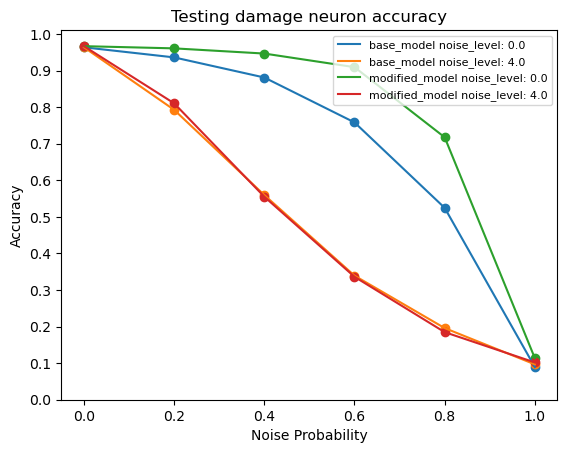

In [1398]:
for lvl in base_acc_dict:
    plt.plot(base_acc_dict[lvl], label="base_model noise_level: {:.1f}".format(lvl))
    plt.scatter([i for i in range(len(noise_prob))], base_acc_dict[lvl])

for lvl in modified_acc_dict:
    plt.plot(modified_acc_dict[lvl], label="modified_model noise_level: {:.1f}".format(lvl))
    plt.scatter([i for i in range(len(noise_prob))], modified_acc_dict[lvl])

plt.title("Testing damage neuron accuracy")
plt.xticks([i for i in range(len(noise_prob))], noise_prob)
plt.yticks([i/10 for i in range(11)])
plt.xlabel("Noise Probability")
plt.ylabel("Accuracy")
plt.legend(loc="upper right", prop={'size':8})
plt.show()